# Appendix

In [1]:
import numpy as np 
import pandas as pd

import itertools
from itertools import chain
from itertools import combinations

from collections import Counter 

import random
import pickle

import networkx as nx
import matplotlib.pyplot as plt 
import matplotlib.patheffects as PathEffects
import seaborn as sns

from statsmodels.formula.api import ols

import pySankey 
from pySankey.sankey import sankey

# [Data Preparation] Section 4.4 -  Regression

In [2]:
df = pd.read_csv("data.csv")

In [3]:
## Drop any rows that don't have project skills 
keep_index_projects = df["project_skills"].dropna().index
df_projects_only = df[df.index.isin(keep_index_projects)]
df_projects_only = df_projects_only.reset_index(drop = True)
len(df_projects_only)

47690

In [4]:
## A list with sublists containing individual projects 
project_skills = df_projects_only["project_skills"].map(lambda x: x.split(" "))
project_skills_full = list(project_skills)
len(project_skills_full)

47690

In [5]:
## Drop any rows that don't have worker skills 
keep_index_workers = df["worker_skills"].dropna().index
df_workers_only = df[df.index.isin(keep_index_workers)]
df_workers_only = df_workers_only.reset_index(drop = True)
len(df_workers_only)

59397

In [6]:
## A list with sublists containing workers who worked on those projects
worker_skills = df_workers_only["worker_skills"].map(lambda x: x.split(" "))
worker_skills_full = list(worker_skills)
len(worker_skills_full)

59397

In [7]:
## Find dataframe that has no missing values for projects AND workers
keep_index_combined = df_projects_only["worker_skills"].dropna().index
df_combined = df_projects_only[df_projects_only.index.isin(keep_index_combined)]
df_combined = df_combined.reset_index(drop = True)
len(df_combined)

47232

In [8]:
## A list with sublists containing individual projects 
project_skills_over = df_combined["project_skills"].map(lambda x: x.split(" "))
project_skills_overlap = list(project_skills_over)
len(project_skills_overlap)

47232

In [9]:
## A list with sublists containing individual projects 
worker_skills_over = df_combined["worker_skills"].map(lambda x: x.split(" "))
worker_skills_overlap = list(worker_skills_over)
len(worker_skills_overlap)

47232

### Section 2.1 [Mentioned] - Mismatching Hypothesis

In [10]:
## Check, out of the TOTAL PROJECTS, how many projects there are where the worker has no overlapping skills 
no_overlap = 0

for p_skill,w_skill in zip(project_skills_overlap,worker_skills_overlap):
    
    if len(set(p_skill) & set(w_skill)) == 0:
        no_overlap = no_overlap + 1
        
no_overlap / len(project_skills_overlap)

0.253027608401084

In [11]:
no_overlap / len(project_skills_full)

0.250597609561753

### Prepare Data for Regression

Get a list of all the unique project skills.  

NOTE: There may be project skills here that are NOT in the overlapping skills

This is ok as this will be used to determine demand. Demand might mean there is a worker that doesn't have the skill. 


In [12]:
## Needed to remove the skills from a list inside a list
skills_flatten = [x for row in project_skills.values for x in row] 
skills_unique = np.unique(skills_flatten)
skills_unique = list(skills_unique)

In [13]:
Full_Reg_df = pd.DataFrame({"Skill": skills_unique, 
                            "Ave_rate_log" : [0] * len(skills_unique), 
                           "Demand_job_list": [0] * len(skills_unique),
                           "Supply_worker_list": [0] * len(skills_unique),
                           "Job_Worker_Match_Perc": [0] * len(skills_unique)})
Full_Reg_df.head()

,Skill,Ave_rate_log,Demand_job_list,Supply_worker_list,Job_Worker_Match_Perc
0,.htaccess,0,0,0,0
1,.net-core,0,0,0,0
2,.net-framework,0,0,0,0
3,1688com-platform,0,0,0,0
4,17hats,0,0,0,0


In [ ]:
## The average price of jobs containing a certain skill

## Takes a few minutes to run

ave_rate = []
for skill in skills_unique: 
    price = df_projects_only[df_projects_only["project_skills"].map(lambda x: skill in x)]["hourly_rate"].mean()
    ave_rate.append(price)

In [ ]:
## The demand of a skill, measured by how many times it appears in a project listing

## Takes a few minutes to run

skill_demand = [] 
for skill in skills_unique: 
    appears = sum(project_skills.map(lambda x: skill in x))
    skill_demand.append(appears)

In [ ]:
## The supply of a skill, measured by how many times it appears in ALL worker listings 

## Takes a few minutes to run

skill_supply = [] 
for skill in skills_unique: 
    appears = sum(worker_skills.map(lambda x: skill in x))
    skill_supply.append(appears)

In [ ]:
## How many times a skill appears in jobs where both the project AND the worker skills are listed 

overlap_dict = dict(zip(skills_unique, [0] * len(skills_unique)))

for p_skill,w_skill in zip(project_skills_overlap, worker_skills_overlap):
    
    overlapping = set(p_skill) & set(w_skill)
    
    if len(overlapping) != 0:
        
        for skill in overlapping: 
            overlap_dict[skill] = overlap_dict[skill] + 1

In [ ]:
## The percentage of skills that is listed on a job and that a candidate has 

match_perc = list(overlap_dict.values()) / Full_Reg_df["Demand_job_list"]

In [ ]:
Full_Reg_df["Ave_rate_log"] = np.log(ave_rate)
Full_Reg_df["Demand_job_list"] = skill_demand
Full_Reg_df["Supply_worker_list"] = skill_supply
Full_Reg_df["Job_Worker_Match_Perc"] = match_perc

#Full_Reg_df.to_csv("RegTable.csv")

In [15]:
Full_Reg_df = pd.read_csv("RegTable.csv").drop(columns=['Unnamed: 0'])

Full_Reg_df.head()

,Skill,Ave_rate_log,Demand_job_list,Supply_worker_list,Job_Worker_Match_Perc
0,.htaccess,3.258942,5,1,0.200000
1,.net-core,3.224560,11,187,0.454545
2,.net-framework,3.181128,172,456,0.348837
3,1688com-platform,2.580217,5,12,0.200000
4,17hats,1.609438,1,0,0.000000


# Section 4.1 - Network Construction

### Data Wrangling

In [16]:
df = pd.read_csv("data.csv")

In [17]:
## Drop any rows that don't have project skills

keep_index_projects = df["project_skills"].dropna().index
df_projects_only = df[df.index.isin(keep_index_projects)]
df_projects_only = df_projects_only.reset_index(drop = True)
len(df_projects_only)

47690

In [18]:
## Get a list of all the unique project skills
## These will form the nodes of the network

skills = df_projects_only["project_skills"].map(lambda x: x.split(" "))
skills_flatten = [x for row in skills.values for x in row] ## Needed to remove the skills from a list inside a list
skills_unique = np.unique(skills_flatten)
skills_unique = list(skills_unique)
len(skills_unique)

4846

In [19]:
## Remove any projects that list only one skill 

skills_list = list(skills)
skills_list =[x for x in skills_list if len(x) > 1]

In [20]:
## Find how how many times two skills are listed together in a project 
## Store the values in a dictionary because it's faster than a dataframe 

skills_dict = {}

for i in range(0, len(skills_list)): 
    
    for combo in combinations(skills_list[i], 2):
        
        key = str(combo[0]) + " " + str(combo[1])
        
        try: 
            current_value = skills_dict[key]
            skills_dict[key] = current_value + 1
        except: 
            skills_dict[key] = 1

In [21]:
## Put the dictionary values in a dataframe 

df_combo = pd.DataFrame(skills_dict.items(), columns=['Skills_Combo', 'Weight'])

df_combo["Skill1"] = df_combo["Skills_Combo"].map(lambda x: x.split(" ")[0])
df_combo["Skill2"] = df_combo["Skills_Combo"].map(lambda x: x.split(" ")[1])

df_combo.head()

,Skills_Combo,Weight,Skill1,Skill2
0,market-research telemarketing,20,market-research,telemarketing
1,adobe-illustrator banner-design,209,adobe-illustrator,banner-design
2,adobe-illustrator illustration,629,adobe-illustrator,illustration
3,adobe-illustrator print-design,473,adobe-illustrator,print-design
4,adobe-illustrator print-layout-design,392,adobe-illustrator,print-layout-design


In [22]:
len(df_combo)

160636

### Create a weighted graph

In [23]:
## Takes around 8 second for full network

## Create an empty graph 
G_weights = nx.Graph()


## Add nodes to network 
[G_weights.add_node(i) for i in skills_unique]

## Iterates through the skills in every project 
for i in range(0,len(df_combo)): 
    
    skill1 = df_combo.loc[i, "Skill1"]
    skill2 = df_combo.loc[i, "Skill2"]

    G_weights.add_edge(skill1, skill2)
    
    weight = df_combo.loc[i, "Weight"] ## Saves the node attributes 
    
    G_weights.edges[(skill1, skill2)]["weight"] = weight

### Degree Centrality

In [24]:
degree_centrality = list(G_weights.degree(weight = "weight"))

dict_central = {}

for nodes in degree_centrality: 
    dict_central[nodes[0]] = nodes[1]


nx.set_node_attributes(G_weights, dict_central, "centrality")

### Section 2.2 [Mentioned] - Degree Centrality

In [25]:
central_demand = list(nx.get_node_attributes(G_weights, "centrality").values())
actual_demand = list(Full_Reg_df["Demand_job_list"])
np.corrcoef(central_demand, actual_demand)

array([[1.        , 0.96199159],
       [0.96199159, 1.        ]])

### Node sizes

In [26]:
node_sizes = np.exp(Full_Reg_df["Ave_rate_log"])

# Section 4.2 - Network Filtering

Using the noise-corrected filtering method. 

The code chunk below was run using a server with the output saved as a csv file.

In [ ]:
null = []

## Get a distribution of the weights in G_weights
edge_dist = list(nx.get_edge_attributes(G_weights, "weight").values())

## Create a distribution of 100 random networks 
for i in range(0,100): 
    
    n = len(G_weights.nodes)
    m = len(G_weights.edges)

    ## Create a random graph with the same number of nodes and edges as G_weights
    G_random = nx.gnm_random_graph(n = n, m = m)
    
    ## Get the edges in the random network 
    edges_random = list(G_random.edges)
    
    ## Randomly assign edges weights from the real network 
    weights_random = np.random.choice(edge_dist, len(G_weights.edges))
    
    ## Create a dictionary with the random edges and randomly assigned weights 
    dict_edges = dict(zip(edges_random, weights_random))

    ## Use this dictionary to set weight attributes 
    nx.set_edge_attributes(G_random, dict_edges, "weight")
    
    ## Find the mean weights of the distribution and save in the null list 
    null.append(np.mean(list(nx.get_edge_attributes(G_random,"weight").values())))
    
df_null = pd.DataFrame({"Weights_Random_Mean":null})
## df_null.to_csv("Null_full_final.csv")

Text(0.5, 1.0, 'Distribution of Edge Weights for Erdos-Renyi Graph')

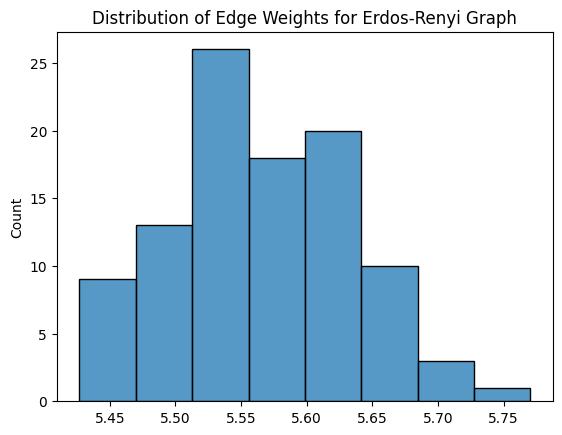

In [27]:
null_df = pd.read_csv("Null_full_final.csv")
null = list(null_df["Weights_Random_Mean"]) 

sns.histplot(null).set_title('Distribution of Edge Weights for Erdos-Renyi Graph')

In [28]:
perc_99 = np.percentile(null, 99)
print(perc_99) ## Threshold 

5.727785960601884


In [29]:
## Make a copy of the network 
G_filter = G_weights.copy()

In [30]:
## Applying the noise corrected filtering 

for edges in G_weights.edges:
    
    node0 = edges[0]
    node1 = edges[1]
    
    edge_value = G_filter.edges[(node0, node1)]["weight"]

    node0_nei = len(list(nx.neighbors(G_filter, node0)))
    node0_cen = G_filter.nodes[node0]["centrality"]
    node0_value = node0_cen / node0_nei

    node1_nei = len(list(nx.neighbors(G_filter, node1)))
    node1_cen = G_filter.nodes[node1]["centrality"]
    node1_value = G_filter.nodes[node1]["centrality"] / node1_nei

    threshold = (node0_value + node1_value) / 2
        
    if (threshold < perc_99): 
        G_filter.remove_edge(node0, node1)
    
        ## Update centrality 
        G_filter.nodes[node0]["centrality"] = (node0_cen - edge_value)
        G_filter.nodes[node1]["centrality"] = (node1_cen - edge_value)

In [31]:
## Weights

print("Edges before filtering: " + str(len(G_weights.edges)))
print("Edges after filtering: " + str(len(G_filter.edges)))

Edges before filtering: 160363
Edges after filtering: 75596


In [32]:
## Remove nodes with no edges 

print("Nodes before filtering: " + str(len(G_filter.nodes)))

for node in list(G_filter.nodes): 
    
    if len(list(nx.neighbors(G_filter, node))) == 0:
        G_filter.remove_node(node)

print("Nodes after filtering: " + str(len(G_filter.nodes)))

Nodes before filtering: 4846
Nodes after filtering: 3915


In [33]:
## Ensure centrality attribute is properly saved 

degree_centrality_fil = list(G_filter.degree(weight = "weight"))

dict_central_fil = {}

for nodes in degree_centrality_fil: 
    dict_central_fil[nodes[0]] = nodes[1]

nx.set_node_attributes(G_filter, dict_central_fil, "centrality")

In [34]:
## Update node sizes

node_sizes_fil = [] 

skill_values = dict(zip(Full_Reg_df["Skill"], np.exp(Full_Reg_df["Ave_rate_log"])))

for node in G_filter.nodes:
    node_sizes_fil.append(skill_values[node])


# Section 4.3 - Community Detection

In [46]:
communities = nx.community.louvain_communities(G_filter, resolution = 1.25, weight = "weight", seed=25,
                                              threshold = 0.01)
print(len(communities)) 
print('')


index = 0
for comm in communities:
    print("Community: " + str(index))
    print("Length: " + str(len(comm)))
    
    print("Most Frequent Words: ")
    draft1 = list(comm)
    draft2 = [item.split("-") for item in draft1]
    draft3 = list(itertools.chain(*draft2))
    draft4 = Counter(draft3)
    print(draft4.most_common(10))
    print()

    index = index + 1


8

Community: 0
Length: 44
Most Frequent Words: 
[('testing', 19), ('test', 11), ('qa', 4), ('management', 2), ('design', 2), ('end', 2), ('regression', 2), ('mobile', 2), ('execution', 2), ('analysis', 2)]

Community: 1
Length: 105
Most Frequent Words: 
[('tax', 16), ('accounting', 10), ('financial', 9), ('and', 7), ('management', 6), ('accounts', 5), ('taxes', 4), ('analysis', 4), ('law', 3), ('intuit', 3)]

Community: 2
Length: 134
Most Frequent Words: 
[('management', 9), ('project', 6), ('development', 5), ('and', 5), ('software', 4), ('microsoft', 4), ('regulatory', 4), ('google', 3), ('scheduling', 3), ('social', 3)]

Community: 3
Length: 414
Most Frequent Words: 
[('marketing', 46), ('google', 25), ('media', 21), ('social', 20), ('seo', 20), ('strategy', 19), ('and', 18), ('management', 14), ('advertising', 13), ('ads', 13)]

Community: 4
Length: 720
Most Frequent Words: 
[('translation', 104), ('english', 97), ('writing', 91), ('and', 24), ('german', 16), ('engineering', 15), 

In [35]:
## Save communities to ensure their order will remain the same

#with open("communities_filtered", "wb") as fp:   
    #pickle.dump(communities, fp)
    
with open("communities_filtered", "rb") as fp:   
    communities = pickle.load(fp)

### Validate communities

The code chunk below was run using a server with the output saved as a csv file

In [ ]:
null_communities = []

n = len(G_filter.nodes)
m = len(G_filter.edges)

## Get a distribution of the weights in G_filter
edge_dist = list(nx.get_edge_attributes(G_filter, "weight").values())


## Create a distribution of 100 random networks 
for i in range(0,100): 
    
    G_random = nx.gnm_random_graph(n = n, m = m)
    
    ## Get the edges in the random network 
    edges_random = list(G_random.edges)
    
    ## Randomly assign edges weights from the real network 
    weights_random = np.random.choice(edge_dist, len(G_weights.edges))
    
    ## Create a dictionary with the random edges and randomly assigned weights 
    dict_edges = dict(zip(edges_random, weights_random))

    ## Use this dictionary to set weight attributes 
    nx.set_edge_attributes(G_random, dict_edges, "weight")
    
    communities_random = nx.community.louvain_communities(G_random, 
                                                          resolution = 1.25, 
                                                          weight = "weight", 
                                                          seed=25,
                                                          threshold = 0.01)
    
    null_communities.append(len(communities_random))

    
df_null = pd.DataFrame({"Communities_Random":null_communities})

## df_null.to_csv("Communities_final.csv")

Text(0.5, 1.0, 'Number of Communities for Random Graph')

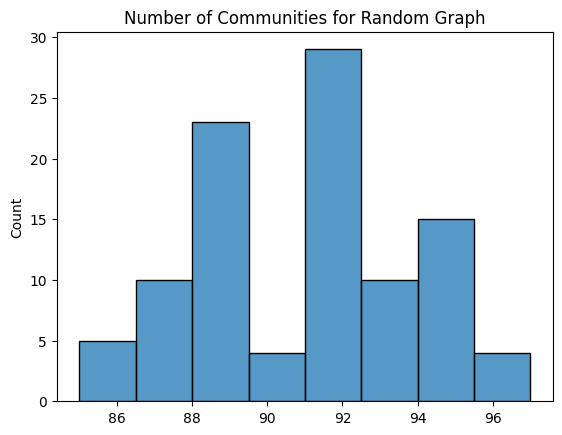

In [36]:
null_df_comm = pd.read_csv("Communities_final.csv")
null_comm = list(null_df_comm["Communities_Random"]) 

sns.histplot(null_comm).set_title('Number of Communities for Random Graph')

In [37]:
perc_bottom_comm = np.percentile(null_comm, 0.05)
perc_top_comm = np.percentile(null_comm, 99.5)

print("The number of communities found in the observed network was " + str(len(communities)))
print("This is smaller than: " + str(perc_bottom_comm))

len(communities) < perc_bottom_comm or len(communities) > perc_top_comm 

The number of communities found in the observed network was 8
This is smaller than: 85.0


True

### New Graph for Plotting Communities 

In [38]:
G_Comm = G_filter.copy()

In [39]:
skill_Testing = communities[0]
skill_Finance = communities[1] 
skill_Admin = communities[2]
skill_Market = communities[3]
skill_Writing = communities[4] 
skill_Tech = communities[5]
skill_Data = communities[6]
skill_Design = communities[7]



for i in G_Comm.nodes:
    
    if i in skill_Design: ## Pink
        G_Comm.nodes[i]["color"] = "#EE73FA" 

    if i in skill_Finance: ## Dark blue
        G_Comm.nodes[i]["color"] = "#204CD5"

    if i in skill_Market: ## Light blue 
        G_Comm.nodes[i]["color"] = "#51D4F7"
        
    if i in skill_Admin: ## Gold
        G_Comm.nodes[i]["color"] = "#DFCA48"
        
    if i in skill_Tech: ##Red
        G_Comm.nodes[i]["color"] = "#ED4646"
        
    if i in skill_Writing: ## Gray
        G_Comm.nodes[i]["color"] = "#78786d"

    if i in skill_Data: ## Purple
        G_Comm.nodes[i]["color"] = "#B475E6"
        
    if i in skill_Testing: ## Green
        G_Comm.nodes[i]["color"] = "#8FE474"
        
        

In [40]:
## Set node colors
node_colors = nx.get_node_attributes(G_Comm, "color")
node_colors = list(node_colors.values())
node_colors = [x for x in node_colors]


In [41]:
## Set edge width
edge_weights = nx.get_edge_attributes(G_Comm, "weight")
edge_width = list(edge_weights.values())
edge_width = [np.log(x)+0.1 for x in edge_width]

### Manually Assign Positions

In [42]:
dict_Design = {} ## Pink
n = len(skill_Design)
x = np.random.normal(loc=0.75, scale=0.2, size=n)
y = np.random.normal(loc=0.75, scale=0.2, size=n)
pos = tuple(zip(x, y))
dict_Design = dict(zip(list(skill_Design), pos))


dict_Finance = {} ## Dark blue 
n = len(skill_Finance)
x = np.random.normal(loc=-1, scale=0.2, size=n)
y = np.random.normal(loc= -1, scale=0.2, size=n)
pos = tuple(zip(x, y))
dict_Finance = dict(zip(list(skill_Finance), pos))


dict_Mark = {} ## Light blue 
n = len(skill_Market)
x = np.random.normal(loc= 0, scale=0.2, size=n)
y = np.random.normal(loc= 0, scale=0.2, size=n)
pos = tuple(zip(x, y))
dict_Mark = dict(zip(list(skill_Market), pos))


dict_Admin = {} ## Gold
n = len(skill_Admin)
x = np.random.normal(loc= -0.5, scale=0.2, size=n)
y = np.random.normal(loc= 0.5, scale=0.2, size=n)
pos = tuple(zip(x, y))
dict_Admin = dict(zip(list(skill_Admin), pos))



dict_Tech = {} ## Red
n = len(skill_Tech)
x = np.random.normal(loc= 0.75, scale=0.2, size=n)
y = np.random.normal(loc= -0.75, scale=0.2, size=n)
pos = tuple(zip(x, y))
dict_Tech = dict(zip(list(skill_Tech), pos))



dict_Writ = {} ## Grey
n = len(skill_Writing)
x = np.random.normal(loc= -1, scale=0.2, size=n)
y = np.random.normal(loc= 1, scale=0.2, size=n)
pos = tuple(zip(x, y))
dict_Writ = dict(zip(list(skill_Writing), pos))


dict_Data = {} ##Purple
n = len(skill_Data)
x = np.random.normal(loc=-0.5, scale=0.2, size=n)
y = np.random.normal(loc= -0.5, scale=0.2, size=n)
pos = tuple(zip(x, y))
dict_Data = dict(zip(list(skill_Data), pos))


dict_Testing= {} ##Green
n = len(skill_Testing)
x = np.random.normal(loc= 0.75, scale=0.1, size=n)
y = np.random.normal(loc= 0, scale=0.1, size=n)
pos = tuple(zip(x, y))
dict_Testing = dict(zip(list(skill_Testing), pos))

pos_manual = dict_Design | dict_Finance | dict_Mark | dict_Admin | dict_Tech | dict_Writ | dict_Data | dict_Testing

In [43]:
pos_manual_df = pd.DataFrame({"nodes" : list(pos_manual.keys()), 
            "positions" : list(pos_manual.values())})

#pos_manual_df.to_csv("pos_manual_save.csv")

In [43]:
pos_manual_df = pd.read_csv("pos_manual_save.csv")

pos_clean = pos_manual_df["positions"].map(lambda x : x.replace('(',""))
pos_clean_2 = pos_clean.map(lambda x : x.replace(')',""))
pos_split = pos_clean_2.map(lambda x : x.split(', '))

pos_list = []

for pos in pos_split: 
    x = float(pos[0])
    y = float(pos[1])
    pos_list.append((x,y))


pos_manual = dict(zip(pos_manual_df["nodes"], pos_list))

### Edge colors 

In [44]:
node_names = (list(skill_Design) + 
              list(skill_Finance) + 
             list(skill_Market) + 
             list(skill_Admin) + 
             list(skill_Tech) + 
             list(skill_Writing) + 
             list(skill_Data) + 
             list(skill_Testing))


node_communities = (["Design"] * len(skill_Design) + 
                    ["Finance"] * len(skill_Finance) + 
                   ["Marketing"] * len(skill_Market) +
                   ["Admin"] * len(skill_Admin) +
                   ["Tech"] * len(skill_Tech) +
                   ["Writing"] * len(skill_Writing) +
                   ["Data"] * len(skill_Data) +
                   ["Testing"] * len(skill_Testing))

dict_community =  dict(zip(list(node_names), node_communities))

In [45]:
## Set attributes for node communities
nx.set_node_attributes(G_Comm, dict_community, "community")

In [46]:
comm_color_dict = {} 

comm_color_dict["Design"] = "#EE73FA" ## Pink
comm_color_dict["Finance"] = "#204CD5" ## Dark Blue
comm_color_dict["Marketing"] = "#51D4F7" ## Light blue
comm_color_dict["Admin"] = "#DFCA48" ## Gold
comm_color_dict["Tech"] = "#ED4646" ## Red
comm_color_dict["Writing"] = "#78786d" ## Gray
comm_color_dict["Data"] =  "#B475E6" ## Purple
comm_color_dict["Testing"] = "#8FE474" ## Green

In [47]:
edge_colors = []
for edge in G_Comm.edges:
    
    node0_comm = G_Comm.nodes[edge[0]]["community"]
    node1_comm = G_Comm.nodes[edge[1]]["community"]
    
    if node0_comm == node1_comm: 
        comm_color = comm_color_dict[node0_comm]
        edge_colors.append(comm_color)
    else: 
        edge_colors.append("#cfcfc9")


### Correct overlapping edges

In [48]:
## Light gray edges
plot_first = []
plot_first_weight = []

## Community coloured edges
plot_second = []
plot_second_weight = []



for edge in G_Comm.edges: 
    
    weight = G_Comm.edges[edge]["weight"]
    
    node0 = edge[0]
    node1 = edge[1]
        
    node0_comm = G_Comm.nodes[node0]["community"]
    node1_comm = G_Comm.nodes[node1]["community"]
    
    if node0_comm != node1_comm: 
        plot_first.append((node0,node1))
        plot_first_weight.append(weight)
        
    if node0_comm == node1_comm:
        plot_second.append((node0,node1))
        plot_second_weight.append(weight)
    

In [49]:
## Make a copy of the network 
G_plot_first = G_Comm.copy()
G_plot_second = G_Comm.copy()

## Remove the edges
G_plot_first.remove_edges_from(G_plot_first.edges())
G_plot_second.remove_edges_from(G_plot_second.edges())

In [50]:
## Add the edges the weights to the new networks 
for edge, weight in zip(plot_first, plot_first_weight):
    
    G_plot_first.add_edge(edge[0], edge[1])
    G_plot_first.edges[edge[0], edge[1]]["weight"] = weight
    
for edge, weight in zip(plot_second, plot_second_weight):
    
    G_plot_second.add_edge(edge[0], edge[1])
    G_plot_second.edges[edge[0], edge[1]]["weight"] = weight

In [51]:
## Add the edge sizes to the new networks
edge_weights_first = nx.get_edge_attributes(G_plot_first, "weight")
edge_width_first = list(edge_weights_first.values())
edge_width_first = [np.log(x)+0.1 for x in edge_width_first]

edge_weights_second = nx.get_edge_attributes(G_plot_second, "weight")
edge_width_second = list(edge_weights_second.values())
edge_width_second = [np.log(x)+0.1 for x in edge_width_second]

In [52]:
## Add the edges colors to the new network 

edge_colors_first = []

for edge in G_plot_first.edges:
    
    node0_comm = G_Comm.nodes[edge[0]]["community"]
    node1_comm = G_Comm.nodes[edge[1]]["community"]
    
    if node0_comm == node1_comm: 
        comm_color = comm_color_dict[node0_comm]
        edge_colors_first.append(comm_color)
    else: 
        edge_colors_first.append("#cfcfc9")
        
        
edge_colors_second= []

for edge in G_plot_second.edges:
    
    node0_comm = G_Comm.nodes[edge[0]]["community"]
    node1_comm = G_Comm.nodes[edge[1]]["community"]
    
    if node0_comm == node1_comm: 
        comm_color = comm_color_dict[node0_comm]
        edge_colors_second.append(comm_color)
    else: 
        edge_colors_second.append("#cfcfc9")

# Figure 1

Text(0.5, 1.0, 'Network of Skills')

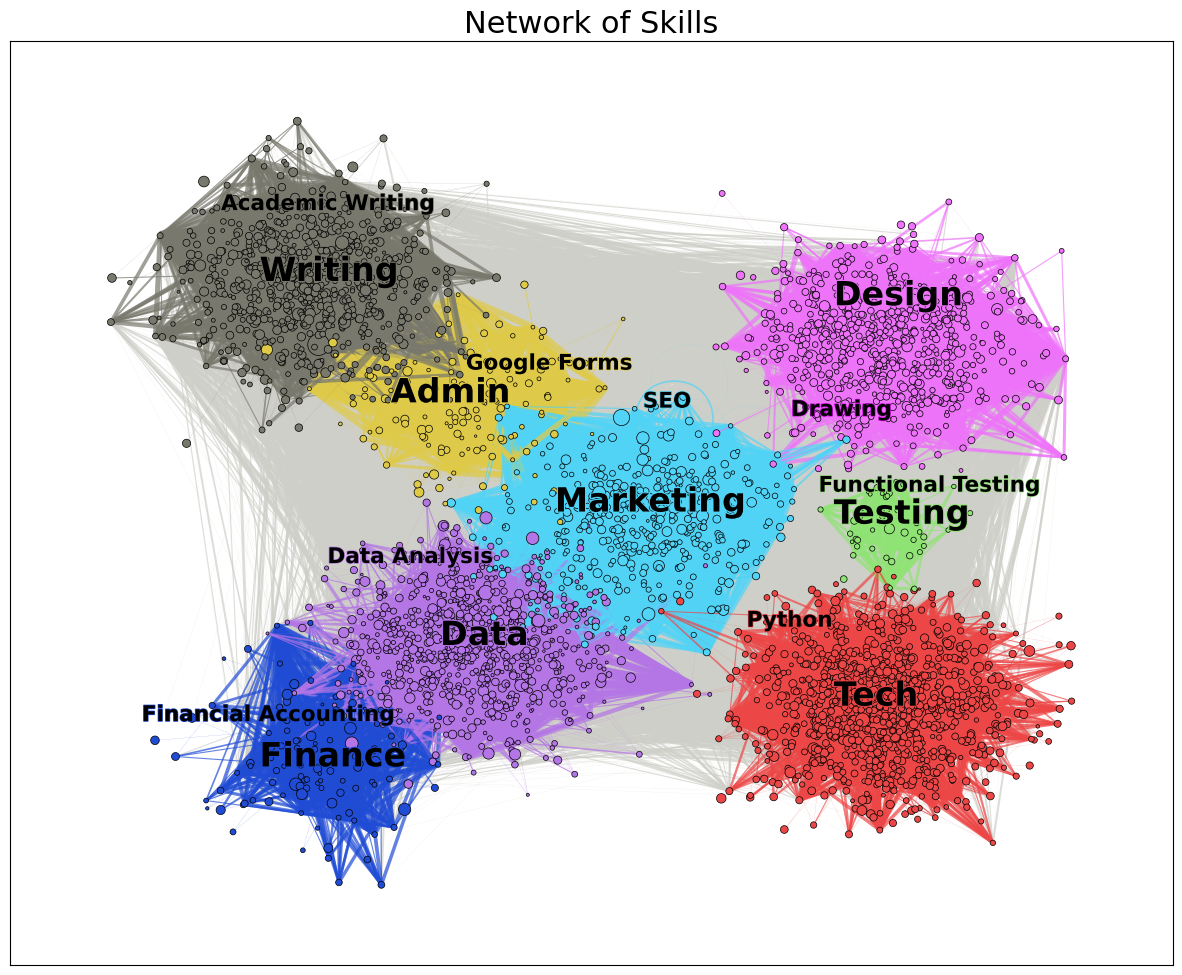

In [53]:
plt.figure(figsize=(15,12)) 

## Plot the light gray edges first
nx.draw_networkx_edges(G_plot_first, pos = pos_manual, width = edge_width_first,
                      edge_color =edge_colors_first, alpha = 0.7)


## Plot the community colored edges on top of them
nx.draw_networkx_edges(G_plot_second, pos = pos_manual, width = edge_width_second,
                      edge_color =edge_colors_second, alpha = 0.7)


## Plot the full network 
nx.draw_networkx_nodes(G_Comm, pos = pos_manual, 
                       node_color = node_colors, 
                       node_size = node_sizes_fil,
                      edgecolors = "black", linewidths = 0.5)


txt = plt.text(0.60, 0.9, 'Design', fontsize = 24, fontweight = "semibold", color = "black")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#EE73FA")])

txt = plt.text(-1.15, -1, 'Finance', fontsize = 24, fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#204CD5")])

txt = plt.text(-0.25, 0.05, 'Marketing', fontsize = 24, fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#51D4F7")])

txt = plt.text(-0.75, 0.5, 'Admin', fontsize = 24, fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#DFCA48")])

txt = plt.text(0.6, -0.75, 'Tech', fontsize = 24, fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#ED4646")])

txt = plt.text(-1.15, 1, 'Writing', fontsize = 24, fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#78786d")])

txt = plt.text(-0.6, -0.5, 'Data', fontsize = 24, fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#B475E6")])

txt = plt.text(0.60, 0, 'Testing', fontsize = 24, fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1.5, foreground = "#8FE474")])



txt = plt.text(pos_manual["drawing"][0] / 2 + 0.10,
         pos_manual["drawing"][1] - 0.30,
         "Drawing",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#d40fe6")])


txt = plt.text(pos_manual["financial-accounting"][0] / 2 - 1.05,
         pos_manual["financial-accounting"][1] - 0.10,
         "Financial Accounting",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#204CD5")])


txt = plt.text(pos_manual["seo"][0] / 2,
         pos_manual["seo"][1] + 0.75,
         "SEO",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#51D4F7")])


txt = plt.text(pos_manual["google-forms"][0] / 2 - 0.35,
         pos_manual["google-forms"][1] - 0.35,
         "Google Forms",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#DFCA48")])


txt = plt.text(pos_manual["python"][0] / 2,
         pos_manual["python"][1] + 0.10,
         "Python",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#ED4646")])


txt = plt.text(pos_manual["academic-writing"][0] / 2 - 0.75,
         pos_manual["academic-writing"][1] + 0.25,
         "Academic Writing",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#78786d")])


txt = plt.text(pos_manual["data-analysis"][0] / 2 - 0.6,
         pos_manual["data-analysis"][1] + 0.20,
         "Data Analysis",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#B475E6")])



txt = plt.text(pos_manual["functional-testing"][0] / 2 + 0.2,
         pos_manual["functional-testing"][1],
         "Functional Testing",
         fontsize = 15.5,  fontweight = "semibold")
txt.set_path_effects([PathEffects.withStroke(linewidth = 1, foreground = "#8FE474")])



plt.title('Network of Skills', fontsize = 22)

#plt.savefig('Fig1.png',  bbox_inches='tight')


# Section 4.4 - Regression

### Data Set Up 

In [54]:
## Get only the skills in the filtered network

filtered_skills = list(G_Comm.nodes)
Network_Reg_df = Full_Reg_df[Full_Reg_df["Skill"].map(lambda x: x in filtered_skills)].reset_index(drop = True)
Network_Reg_df.head()

,Skill,Ave_rate_log,Demand_job_list,Supply_worker_list,Job_Worker_Match_Perc
0,.htaccess,3.258942,5,1,0.200000
1,.net-core,3.224560,11,187,0.454545
2,.net-framework,3.181128,172,456,0.348837
3,1688com-platform,2.580217,5,12,0.200000
4,17hats,1.609438,1,0,0.000000


In [55]:
## Add the degree centrality and community information to the dataframe 

skills_cent = list(nx.get_node_attributes(G_Comm, "centrality").values())
skills_comm = list(nx.get_node_attributes(G_Comm, "community").values())

Network_Reg_df["Community"] = skills_comm
Network_Reg_df["Log_centrality"] = np.log(skills_cent)

Network_Reg_df.head()

,Skill,Ave_rate_log,Demand_job_list,Supply_worker_list,Job_Worker_Match_Perc,Community,Log_centrality
0,.htaccess,3.258942,5,1,0.200000,Tech,2.564949
1,.net-core,3.224560,11,187,0.454545,Tech,2.772589
2,.net-framework,3.181128,172,456,0.348837,Tech,5.849325
3,1688com-platform,2.580217,5,12,0.200000,Writing,2.302585
4,17hats,1.609438,1,0,0.000000,Data,1.098612


In [56]:
## Verify the information in Figure 1

print("drawing" in list(Network_Reg_df[Network_Reg_df["Community"] == "Design"]["Skill"]))
print("financial-accounting" in list(Network_Reg_df[Network_Reg_df["Community"] == "Finance"]["Skill"]))
print("seo" in list(Network_Reg_df[Network_Reg_df["Community"] == "Marketing"]["Skill"]))
print("google-forms" in list(Network_Reg_df[Network_Reg_df["Community"] == "Admin"]["Skill"]))
print("python" in list(Network_Reg_df[Network_Reg_df["Community"] == "Tech"]["Skill"]))
print("academic-writing" in list(Network_Reg_df[Network_Reg_df["Community"] == "Writing"]["Skill"]))
print("data-analysis" in list(Network_Reg_df[Network_Reg_df["Community"] == "Data"]["Skill"]))
print("functional-testing" in list(Network_Reg_df[Network_Reg_df["Community"] == "Testing"]["Skill"]))

True
True
True
True
True
True
True
True


# Figure 2

Text(0.5, 1.0, 'Average Log Rate for Skills in Each Sector')

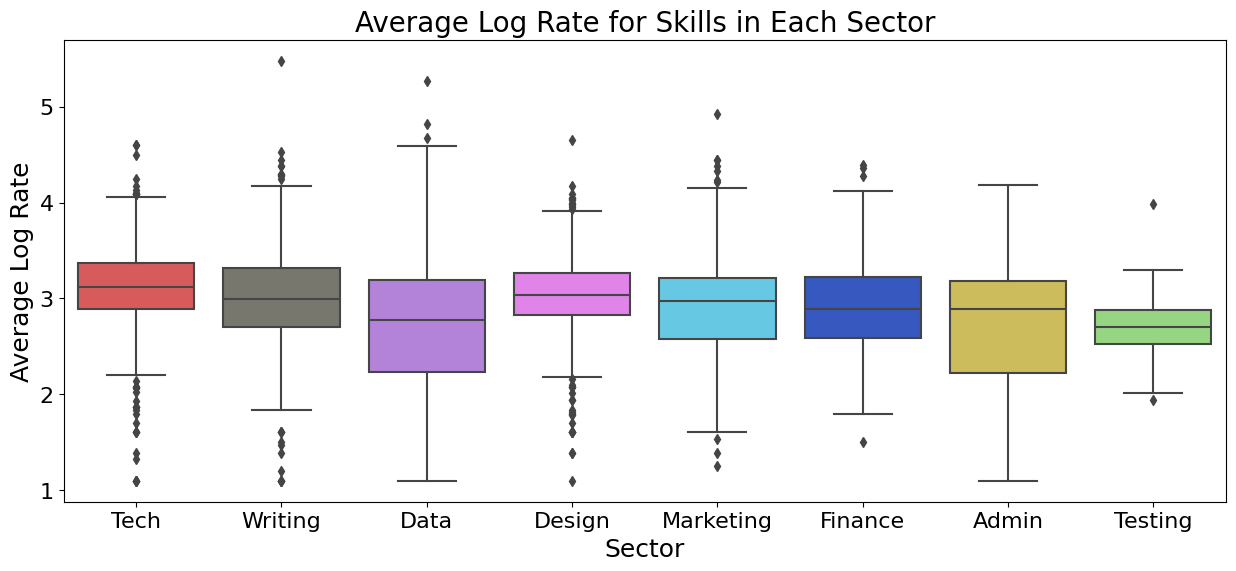

In [57]:
plt.figure(figsize=(15,6)) 


ax = sns.boxplot(data = Network_Reg_df,  
            x="Community", 
            y="Ave_rate_log", 
            hue="Community", 
            palette = comm_color_dict,
           dodge=False)
plt.legend([],[], frameon=False)



ax.set_ylabel("Average Log Rate", fontsize = 18)
ax.set_xlabel("Sector", fontsize = 18)
ax.tick_params(axis='y',labelsize=16)
ax.tick_params(axis='x',labelsize=16)


plt.title('Average Log Rate for Skills in Each Sector', fontsize = 20)

#plt.savefig('Fig2.png',  bbox_inches='tight')


### Descriptive Table 

In [58]:
community_names = ["Design", "Finance", "Marketing", "Admin",
                   "Tech", "Writing", "Data", "Testing"]

In [59]:
## Find the number of edges in each community 

full_edges = [len(G_Comm.edges)]

dict_number_edges = dict(zip(community_names, [0] * 8))


for edge in G_Comm.edges:
    
    node0_comm = G_Comm.nodes[edge[0]]["community"]
    node1_comm = G_Comm.nodes[edge[1]]["community"]
    
    if node0_comm == node1_comm: 
        
        dict_number_edges[node0_comm] = dict_number_edges[node0_comm] + 1
        
        
[full_edges.append(x) for x in list(dict_number_edges.values())]


[None, None, None, None, None, None, None, None]

In [60]:
## Find the mean and sd edge weights of each community 

weight_mean = [np.mean(np.log(list(nx.get_edge_attributes(G_Comm, "weight").values())))]
weight_sd = [np.std(np.log(list(nx.get_edge_attributes(G_Comm, "weight").values())))]

def weight_stats(comm):
    
    temp_list = []
    
    for edge in G_Comm.edges:
    
        node0_comm = G_Comm.nodes[edge[0]]["community"]
        node1_comm = G_Comm.nodes[edge[1]]["community"]
    
        if node0_comm == comm: 
            
            temp_list.append(G_Comm.edges[edge]["weight"])
            
    return(np.mean(temp_list), np.std(temp_list))

for comm in community_names: 
    
    wei_mean, wei_sd = weight_stats(comm)
    
    weight_mean.append(wei_mean)
    weight_sd.append(wei_sd)

In [61]:
## Find the mean and sd centrality of nodes in each community 

centrality_mean = [np.mean(np.log(list(nx.get_node_attributes(G_Comm, "centrality").values())))]
centrality_sd = [np.std(np.log(list(nx.get_node_attributes(G_Comm, "centrality").values())))]

def centrality_stats(comm): 
    
    temp_list = []
    
    for node in G_Comm.nodes:
        
        if G_Comm.nodes[node]["community"] == comm:
            temp_list.append(np.log(G_Comm.nodes[node]["centrality"]))
            
    return(np.mean(temp_list), np.std(temp_list))


for comm in community_names: 
    
    cen_mean, cen_sd = centrality_stats(comm)
    
    centrality_mean.append(cen_mean)
    centrality_sd.append(cen_sd)


In [62]:
## Find the mean and sd log average rate for skills in each community 

rate_mean = [Network_Reg_df["Ave_rate_log"].mean()]
rate_sd = [Network_Reg_df["Ave_rate_log"].std()]


for comm in community_names: 
    
    sal_mean = Network_Reg_df[Network_Reg_df["Community"] == comm]["Ave_rate_log"].mean()
    sal_std = Network_Reg_df[Network_Reg_df["Community"] == comm]["Ave_rate_log"].std()

    rate_mean.append(sal_mean)
    rate_sd.append(sal_std)

# Table 1

In [63]:

df_descriptive = pd.DataFrame({"Info": ["Full Network", 
                                        "Design", "Finance", "Marketing", "Admin",
                                        "Tech", "Writing", "Data", "Testing"],
                               
                               "Number of Nodes": [len(G_Comm.nodes), 
                                                  len(skill_Design), len(skill_Finance),
                                                   len(skill_Market), len(skill_Admin),
                                                   len(skill_Tech), len(skill_Writing), 
                                                   len(skill_Data), len(skill_Testing)],
                               "Number of Edges": full_edges,
                               
                               "Log Edge Weight Mean" : weight_mean,
                               "Log Edge Weight Standard Deviation": weight_sd,
                               
                               "Log Centrality Mean": centrality_mean, 
                               "Log Centrality Standard Deviation": centrality_sd,
                               
                               "Log Hourly Rate Mean": rate_mean,
                               "Log Hourly Rate Standard Deviation": rate_sd
                                    })
round(df_descriptive, 2)

,Info,Number of Nodes,Number of Edges,Log Edge Weight Mean,Log Edge Weight Standard Deviation,Log Centrality Mean,Log Centrality Standard Deviation,Log Hourly Rate Mean,Log Hourly Rate Standard Deviation
0,Full Network,3915,75596,1.03,1.24,3.05,2.23,2.95,0.54
1,Design,649,5373,8.94,41.86,3.06,2.19,3.03,0.42
2,Finance,105,809,8.38,17.51,3.52,2.18,2.94,0.57
3,Marketing,414,10493,10.40,32.42,4.57,2.41,2.94,0.53
4,Admin,134,1049,10.73,32.03,3.43,2.58,2.74,0.59
5,Tech,997,9202,9.68,56.28,2.66,2.03,3.11,0.42
6,Writing,720,5657,8.82,34.97,2.76,2.06,3.00,0.53
7,Data,852,7726,9.51,45.46,2.88,2.17,2.73,0.67
8,Testing,44,173,8.80,17.73,3.52,1.95,2.71,0.36


# Table 2

In [64]:
## Perform regression for each community 

for comm in community_names: 
    df_temp = Network_Reg_df[Network_Reg_df["Community"] == comm]
    
    max_value_skill = list(df_temp[df_temp["Ave_rate_log"] == df_temp["Ave_rate_log"].max()]["Skill"])[0]
    
    lm = ols('Ave_rate_log ~ 1 + Demand_job_list + Supply_worker_list + Log_centrality + Job_Worker_Match_Perc', 
         data = df_temp).fit()
    
    print("Community: " + comm)
    print(lm.summary())
    print("")
    print("")
    print("")
    print("")

Community: Design
                            OLS Regression Results                            
Dep. Variable:           Ave_rate_log   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4340
Date:                Mon, 29 Apr 2024   Prob (F-statistic):              0.784
Time:                        10:58:02   Log-Likelihood:                -356.79
No. Observations:                 648   AIC:                             723.6
Df Residuals:                     643   BIC:                             746.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept   

## Sankey Diagram 

In [65]:
## Create the left and right side of the Sankey diagram 

comm_left = [] 
comm_right = [] 

for edge in G_Comm.edges: 
    node0 = edge[0]
    node1 = edge[1]
        
    node0_comm = G_Comm.nodes[node0]["community"]
    node1_comm = G_Comm.nodes[node1]["community"]
    
    comm_left.append(node0_comm)
    comm_right.append(node1_comm)

In [66]:
df_sankey = pd.DataFrame({"Left": comm_left,
                        "Right": comm_right})

In [67]:
comm_color_dict_sankey = {} 

comm_color_dict_sankey["Design"] = "#d40fe6" ## Pink
comm_color_dict_sankey["Finance"] = "#204CD5" ## Dark Blue
comm_color_dict_sankey["Marketing"] = "#0bb6e5" ## Light blue
comm_color_dict_sankey["Admin"] = "#DFCA48" ## Gold
comm_color_dict_sankey["Tech"] = "#ED4646" ## Red
comm_color_dict_sankey["Writing"] = "#78786d" ## Gray
comm_color_dict_sankey["Data"] =  "#8627d3" ## Purple
comm_color_dict_sankey["Testing"] = "#8FE474" ## Green

# Figure 3

Text(0.5, 1.0, 'Edges Within and Between Sectors')

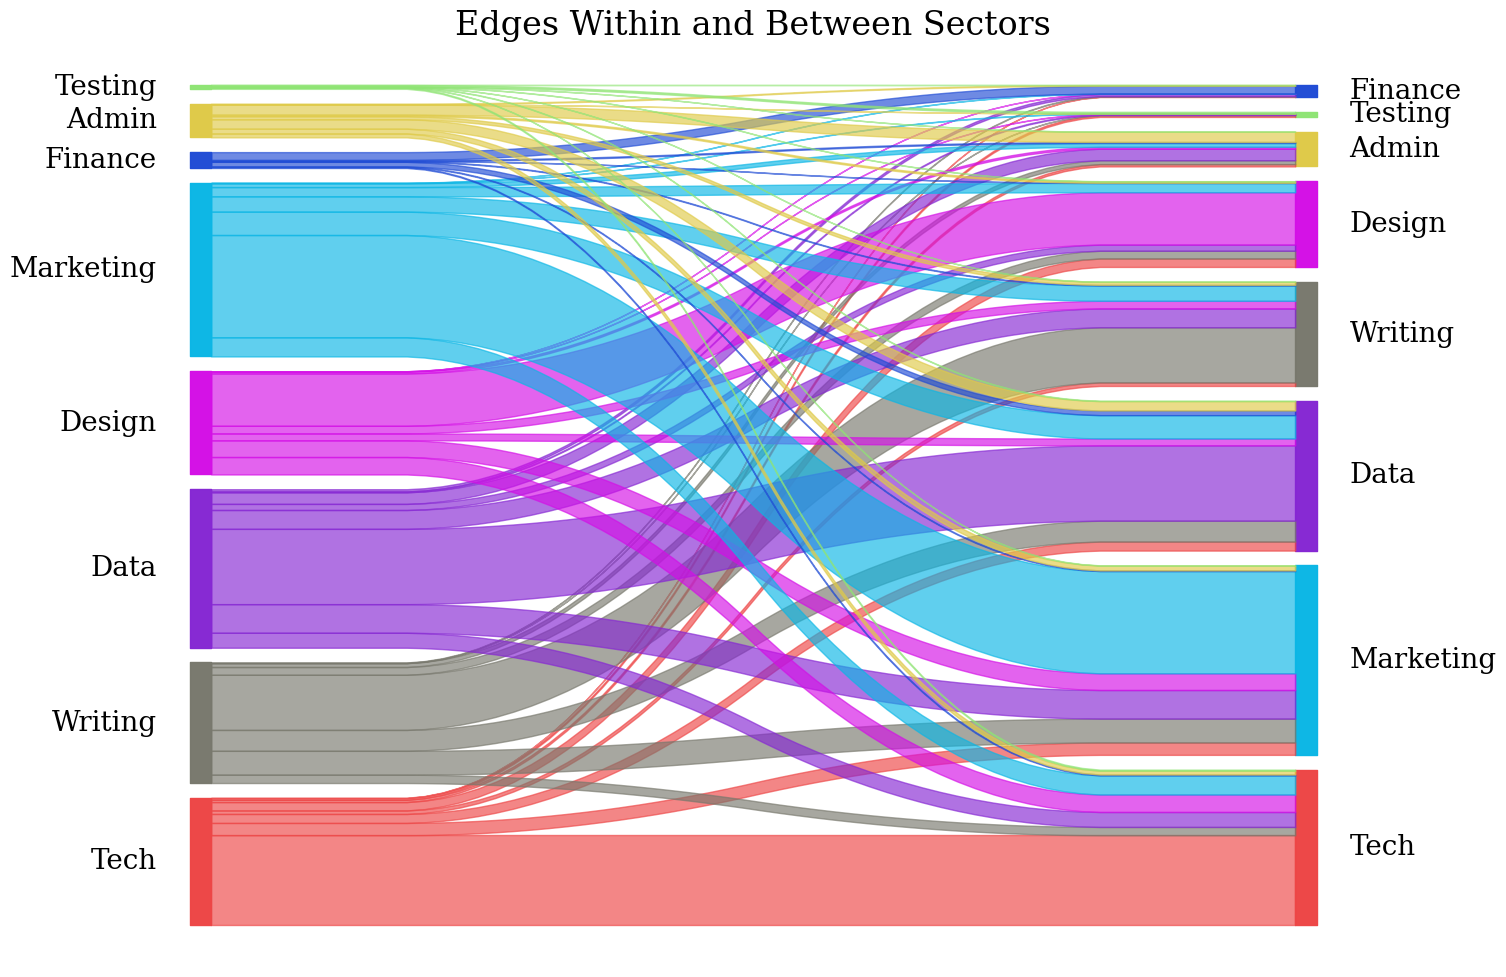

In [68]:
ax = sankey(
    left=df_sankey["Left"], right=df_sankey["Right"], fontsize=20, colorDict = comm_color_dict_sankey
)


plt.gcf().set_size_inches(16, 12)

plt.title('Edges Within and Between Sectors', fontsize = 24)

#plt.savefig('Fig2.png',  bbox_inches='tight')
